<a href="https://colab.research.google.com/github/danih02/RAG-Pipeline-with-Google-OpenAI-Studio---Getting-recipes-from-German-Cookbook/blob/main/RAG_Pipeline_with_Google_OpenAI_Studio_Getting_recipes_from_German_Cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this workbook, we will consider a LangChain RAG to extract information out of a german cookbook - Das gute Essen: Mit 500 Rezepten für jeden Tag. We aim to extract specific information from this book like


1.   What recipe is on page x?
2.   Give me a recipe from the book containing Paprika.
3.   I have Paprika, eggs and cucumber in my fridge. Give me recipes where at least 2 of those ingridients are used.


The llm of consideration is a free tier from google OpenAI Studio - Gemini 2.0 Pro

# Install dependencies, get LLM and inspect document

As already mentioned, we will use a LangChain pipeline.

In [28]:
%%capture
%pip install langchain pypdf faiss-cpu sentence-transformers transformers langchain-community langchain_google_genai PyMuPDF

In [29]:
import pandas as pd
from langchain.document_loaders import PyPDFLoader # document loader for PDF
from langchain.text_splitter import RecursiveCharacterTextSplitter # text splitter
from langchain.embeddings import HuggingFaceEmbeddings # embedding model for FAISS
from langchain.vectorstores import FAISS # faiss retriever
from langchain.chains import RetrievalQA # LangChain RAG pipeline
from langchain.retrievers import BM25Retriever  # BM25 retriever
from langchain.retrievers import EnsembleRetriever # ensemlbe retriever to combine FAISS and BM25

We are going to use a hybrid retriever: FAISS and BM25. In this setup, bm25 is possibly more useful that embedding queries. This is because recipes are of a more structured than semantic type and we will likely search for specific keywords like Paprika or Cucumber.

In [30]:
import os
pdf_path = "Das gute Essen - Kochbuch.pdf"
loader = PyPDFLoader(pdf_path) # PyPDF load the documents pagewise
documents = loader.load()

PyPDFLoader loads the document page wise. This might be a problem for quering as on some pages of this book there are multiple recipes while for some pages there is a single recipe per page. We will already initilize the llm.

In [31]:
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI

api_key = os.environ.get("GOOGLE_API_KEY")
genai.configure(api_key=api_key)

os.environ["GOOGLE_API_KEY"] = api_key
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature = 0)

We can initialize a Prompt. Important for us is the the LLM only uses the context provided. Notice that take a prompt in german as this is the cookbook language.

In [32]:
from langchain import PromptTemplate

# create a prompt template with the "input_prompt" and "context" variables
template = """
{input_prompt}

Für deine Antwort, nutze nur folgenden Kontext:
{context}

Anworte strukturiert in folgender Form:

**Rezeptname**: [Name des Rezepts]

**Zutaten**: [Liste der Zutaten, die für das Rezept benötigt werden]

**Zubereitung**: [Schritt-für-Schritt-Anleitung zur Zubereitung des Rezepts]

**Seite**: [Seitenzahl des Rezepts im Kochbuch]

Falls sich in dem Kontext mehr als ein Rezept befindet, gebe alle an, außer es wird nur nach einem Rezept gefragt.


"""
prompt = PromptTemplate(template=template, input_variables=["input_prompt", "context"])

Define a simple chain which takes the prompt and feeds it into the llm

In [33]:
chain_example = prompt | llm

We now define two number index_single_recipe and index_multiple_recipe, which represent page numbers on in the wook with single and multiple recipes, respectively. These two pages will be our example and test cases throughout. We will print these recipes. 

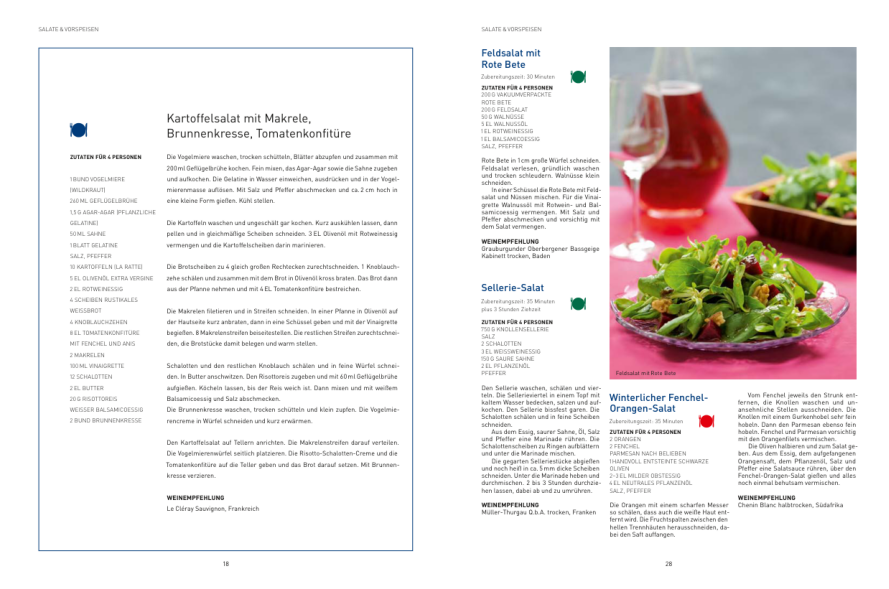

In [34]:
import fitz  # PyMuPDF
import matplotlib.pyplot as plt
from PIL import Image

index_single_recipe = 17
index_multiple_recipes = 27

# Open the PDF
doc = fitz.open("Das gute Essen - Kochbuch.pdf")

# Convert pages to images
pages = [doc[index_single_recipe].get_pixmap(), doc[index_multiple_recipes].get_pixmap()]

# Plot images
fig, axes = plt.subplots(1, 2, figsize=(9, 6))
for ax, pix in zip(axes, pages):
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [35]:
query = 'Erzähl mit etwas über das Rezept auf der Seite.'
context = documents[index_single_recipe].page_content
output = chain_example.invoke({'input_prompt' : query, 'context' : context}).content
print(output)

**Rezeptname**: Kartoffelsalat mit Makrele, Brunnenkresse, Tomatenkonfitüre

**Zutaten**:
* 1 Bund Vogelmiere (Wildkraut)
* 260 ml Geflügelbrühe
* 1,5 g Agar-Agar (pflanzliche Gelatine)
* 50 ml Sahne
* 1 Blatt Gelatine
* Salz, Pfeffer
* 10 Kartoffeln (La Ratte)
* 5 EL Olivenöl extra vergine
* 2 EL Rotweinessig
* 4 Scheiben rustikales Weißbrot
* 4 Knoblauchzehen
* 8 EL Tomatenkonfitüre mit Fenchel und Anis
* 2 Makrelen
* 100 ml Vinaigrette
* 12 Schalotten
* 2 EL Butter
* 20 g Risottoreis
* Weißer Balsamicoessig
* 2 Bund Brunnenkresse

**Zubereitung**:
1. Vogelmiere waschen, trocken schütteln, Blätter abzupfen und mit 200 ml Geflügelbrühe kochen. Fein mixen, Agar-Agar und Sahne zugeben und aufkochen. Gelatine in Wasser einweichen, ausdrücken und in der Vogelmierenmasse auflösen. Mit Salz und Pfeffer abschmecken und ca. 2 cm hoch in eine kleine Form gießen. Kühl stellen.
2. Kartoffeln waschen und ungeschält gar kochen. Kurz auskühlen lassen, dann pellen und in gleichmäßige Scheiben schnei

and we do the same for the multiplce page document without changing the query.

In [36]:
query = 'Erzähl mit etwas über das Rezept auf der Seite.'
context = documents[index_multiple_recipes].page_content
output = chain_example.invoke({'input_prompt' : query, 'context' : context}).content
print(output)

**Rezeptname**: Winterlicher Fenchel-Orangen-Salat

**Zutaten**: 2 Orangen, 2 Fenchel, Parmesan nach Belieben, 1 Handvoll entsteinte schwarze Oliven, 2-3 EL milder Obstessig, 4 EL neutrales Pflanzenöl, Salz, Pfeffer

**Zubereitung**:
1. Vom Fenchel den Strunk entfernen, die Knollen waschen und unansehnliche Stellen ausschneiden. Die Knollen mit einem Gurkenhobel sehr fein hobeln. Dann den Parmesan ebenso fein hobeln.
2. Die Orangen so schälen, dass auch die weiße Haut entfernt wird. Die Fruchtspalten zwischen den hellen Trennhäuten herausschneiden, dabei den Saft auffangen.
3. Fenchel und Parmesan vorsichtig mit den Orangenfilets vermischen. Die Oliven halbieren und zum Salat geben.
4. Aus dem Essig, dem aufgefangenen Orangensaft, dem Pflanzenöl, Salz und Pfeffer eine Salatsauce rühren, über den Fenchel-Orangen-Salat gießen und alles noch einmal behutsam vermischen.

**Seite**: 28

**Rezeptname**: Feldsalat mit Rote Bete

**Zutaten**: 200g vakuumverpackte Rote Bete, 200g Feldsalat, 50g

Let us display the pdf pages to manually check how accurate our llm was:

Comparing the llms output to the actual recipes, we see that it did a really good job for the first single recipe. For the multiple recipe page it worked just as good with extraction of every single recipe. This is due to the specific prompt that everything should be extracted.

# Splitting the Document

From the previous two examples we see that some pages can contain multiple recipes. This might cause problems: Imagine if we are asking for a mediteran dish. As we are not asking specific ingridients this resembles for an embedding type of problem. But it is very possible that on a single page are not only mediteran dish, so embedding might not work as intended.

So what we would want to have is the document split into recipes. We approach this problem in two steps.

1.   Classical text splitter like RecursiveTextSplitter do not split the text in reading order. So we need to split the pages text in our own way.
2.   Afterwards, we split each page containing multiple recipes into single chunks.



## Bringng pages into reading order

The easiest way to do this is to simply as an llm to do it. As we saw above, this works reasonable. However, Google's OpenAI Studio free tier cannot do this and I don't wont to pay for it.

The idea is the following: we split each page vertically into 3 parts of same width. In this way we are going to seperate recipes as above. For recipes on a single page this will not cause any troubles as the ingridients list and how to prepare it are written block-wise.

In [37]:
%%capture
%pip install pymupdf

In [38]:
import fitz  # PyMuPDF

pdf_path = "Das gute Essen - Kochbuch.pdf"
doc = fitz.open(pdf_path)

all_text_blocks = []

# save origin, i.e., (x,y) coordinates of lines, page_num and text into a dictionary
for page_num, page in enumerate(doc):
    blocks = page.get_text("dict")["blocks"]
    for block in blocks:
        if "lines" in block:
            for line in block["lines"]:
                for span in line["spans"]:
                    text = span["text"]
                    origin = span["origin"]
                    size = span["size"]
                    if text:
                        all_text_blocks.append({
                            "text": text, # text of document
                            "page": page_num + 1, # pages
                            "origin" : origin, # coordinates needed for rearranging pages
                            "size" : size # size to identify headers
                        })

As an example we will print the index_single_recipe from all_text_blocks

In [39]:
all_text_blocks[100]

{'text': 'Dr. Cordes: Gutes Essen basiert auf guten, nachhaltig oder zumindest regional an\xad',
 'page': 5,
 'origin': (144.6280975341797, 622.48828125),
 'size': 8.982132911682129}

In [40]:
for block in all_text_blocks:
    if block['page'] == index_single_recipe + 1:
        print(block['text']) # every text is a new line on the page

Salate & Vorspeisen
18
Kartoffelsalat mit Makrele,  
Brunnenkresse, Tomatenkonfitüre 
Die Vogelmiere waschen, trocken schütteln, Blätter abzupfen und zusammen mit 
200 ml Geflügelbrühe kochen. Fein mixen, das Agar-Agar sowie die Sahne zu­geben 
und aufkochen. Die Gelatine in Wasser ein­weichen, ausdrücken und in der Vogel-
mierenmasse auflösen. Mit Salz und Pfeffer abschmecken und ca. 2 cm hoch in 
eine kleine Form gießen. Kühl stellen.
Die Kartoffeln waschen und ungeschält gar kochen. Kurz auskühlen lassen, dann 
pellen und in gleichmäßige Scheiben schneiden. 3 EL Olivenöl mit Rotweinessig 
vermengen und die Kartoffelscheiben darin marinieren. 
Die Brotscheiben zu 4 gleich großen Rechtecken zurechtschneiden. 1 Knoblauch-
zehe schälen und zusammen mit dem Brot in Olivenöl kross braten. Das Brot dann 
aus der Pfanne nehmen und mit 4 EL Tomatenkonfitüre bestreichen.
Die Makrelen filetieren und in Streifen schneiden. In einer Pfanne in Olivenöl auf 
der Hautseite kurz anbraten, dann in ei

Even tought the ingridients list at the bottom, this will likely not cause a problem for the llm. To highlight the problem with multiples recipes consider the multiple recipes page. Plotting just the first we line we can already see the problem:

In [41]:
i = 0
for block in all_text_blocks:
    if block['page'] == index_multiple_recipes + 1:
        i += 1
        print(block['text']) # every text is a new line on the page
        if i == 5:
            break

Salate & Vorspeisen
28
Vom Fenchel jeweils den Strunk ent­
fernen, die Knollen waschen und un­
ansehnliche Stellen ausschneiden. Die 


Comparing with the picture above, the first lines are just some lines of the last recipe on the bottom right. But we want the recipes in logical reading order. We split the coordinates in 'origin' into x and y coordinates.

In [42]:
import pandas as pd
text = []
origin_x = []
origin_y = []
page = []
size = []
for block in all_text_blocks:
    text.append(block['text'])
    origin_x.append(block['origin'][0])
    origin_y.append(block['origin'][1])
    page.append(block['page'])
    size.append(block['size'])

df = pd.DataFrame({'text' : text, 'origin_x' : origin_x, 'origin_y' : origin_y, 'page' : page, 'size' : size})
df.head()

,text,origin_x,origin_y,page,size
0,MIT 500 REZEPTEN,200.801605,595.130798,1,23.0
1,FÜR JEDEN TAG,219.017609,622.270752,1,23.0
2,KOCHBUCH,200.891800,157.897400,1,36.0
3,2,298.123505,775.559265,2,9.0
4,Vorwort,39.586601,30.614380,2,8.0


Now we split each page into 3 parts 'left', 'middle' and 'right'. This is decided by the values of x and the width of the page. Note that the pages are all of the same size.

In [43]:
page = doc[0]
page_height = page.rect.height
page_width = page.rect.width
splitter_num = [page_width/3, page_width/2, page_width]
splitter_cat = ['left','middle','right']

In [44]:
# function which assign 'left', 'middle' or 'right on dataframe depending on origin_x value
def get_position(x):
    if 0 <= x <= splitter_num[0]:
        return splitter_cat[0]
    elif splitter_num[0] < x <= splitter_num[1]:
        return splitter_cat[1]
    elif splitter_num[1] < x <= splitter_num[2]:
        return splitter_cat[2]
    else:
        raise ValueError(f"x={x} is out of bounds for the defined splitter range.")

df['position'] = df['origin_x'].apply(get_position)

Let us test this on our multiple recipe page

In [45]:
dashed_line = "-" * 100 # create dashed line for structured output

In [46]:
for split in splitter_cat:
    print(f'Position: {split}\n')
    for _, text in df[(df['position'] == split) & (df['page'] == index_multiple_recipes)][['text','size']].iterrows():
        print(text['text'], text['size']) # plot text and size
    print(dashed_line)

Position: left

Möhre und Kohlrabi schälen, Sellerie put- 9.0
zen und waschen, alles in sehr kleine Wür- 8.996349334716797
fel schneiden. Die Champignons putzen  9.04553508758545
und ebenfalls in kleine ­Würfel schneiden.  9.0
Den Spargel falls nötig im unteren Drittel  9.0
schälen, die Enden ab­schneiden, Spargel  9.0
waschen und in 2 cm lange Stücke schnei- 9.0
den, dabei die Köpfe ganz lassen. Die To- 9.0
mate mit heißem Wasser überbrühen,  9.089554786682129
mit kaltem Wasser ab­schrecken und die  9.0
Haut abziehen. Die Tomate erst halbieren,  9.0
die Kerne entfernen und dann in Würfel  9.007646560668945
schneiden. Mit 3 EL ­Mayonnaise und Ket- 9.0
chup verrühren, mit Salz, Pfeffer und 1 Pri- 8.976218223571777
se Zucker abschmecken. 9.0
Für die Vinaigrette Essig, Salz, Pfeffer  9.0
und 1 Prise Zucker verrühren und die rest- 9.0
liche Mayonnaise unterziehen. 9.0
Die Champignons in einer Pfanne mit  9.0
Butter leicht anbraten und herausnehmen.  8.959006309509277
Den Spargel in die Pfa

We see that this workes quite well and the text is in a chronological order. In this way we will now restructure ever page. Moreover, we can make an important observation: the recipe header have text size 14. In this way we can identify header via the text size on this, and hopefully every other, page. To identify the header, we introduce the token [HEAD] to split the recipes. From the pictures above, we also see that single recipe pages have bigger sizes that multiple recipe pages. Let us check the size of this recipe as well. We only print the middle part as this contains the header

In [47]:
print(f'Position: middle\n')
counter = 0
for _, text in df[(df['position'] == 'middle') & (df['page'] == index_single_recipe + 1)][['text','size']].iterrows():
    print(text['text'], text['size']) # plot text and size
    counter += 1
    if counter == 4:
        break # break condition to only sample first few lines

Position: middle

18 9.0
Kartoffelsalat mit Makrele,   17.0
Brunnenkresse, Tomatenkonfitüre  17.0
Die Vogelmiere waschen, trocken schütteln, Blätter abzupfen und zusammen mit  9.0


Hence, we see that for (this) single recipe page, the header has size 17. We do the following then: add the header tokens to every text with 14 <= size <= 17.  

In [48]:
import numpy as np
np.max(df['page'])

321

In [49]:
document_sorted = []
pages_num = []

for page in range(np.max(df['page'])):  # loop through pages
    page_text = ''
    in_header = False  # tracks if we're currently inside a header block
    for split in splitter_cat:  # loop through 'left', 'middle', 'right'
        for _, row in df[(df['position'] == split) & (df['page'] == page)][['text', 'size']].iterrows():
            text = row['text']
            size = row['size']

            if (size >= 14) & (size <= 17):
                if not in_header:
                    # start a header block
                    page_text += " [HEAD] "
                    in_header = True
                page_text += f"{text} "
            else:
                if in_header:
                    # close the header block
                    in_header = False
                page_text += f"{text} "

    if in_header:
        # close any unclosed header block at end of page
        in_header = False

    pages_num.append(str(page))  # keep track of page
    document_sorted.append(page_text.strip())

df_sorted = pd.DataFrame({'text': document_sorted, 'pages': pages_num})

In [50]:
import re
def clean_text(text):
    text = text.strip()  # Remove leading/trailing spaces
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
    text = re.sub(r'\s([?.!"])', r'\1', text)  # Remove space before punctuation
    return text

In [51]:
df_sorted['text'] = df_sorted['text'].apply(lambda x : clean_text(x))

In [52]:
df_sorted['text'].iloc[26]

'Salate & Vorspeisen [HEAD] Herbstlicher Feldsalat Zubereitungszeit: 45 Minuten Zutaten für 4 Personen 400 g Kürbis 100 g Feldsalat 3 EL Kürbiskerne 6 EL Pflanzenöl Salz, Pfeffer 1 EL brauner Zucker 3 EL Weinessig Den Kürbis schälen und in schmale \xadSpal\xadten schneiden. Den Feldsalat verlesen, \xadwaschen und trocken schleudern. Die Kürbiskerne ohne Zugabe von Fett in einer Pfanne an- rösten. In einer Pfanne 4 EL Öl erhitzen, die Kürbis\xadspalten bei geringer Hitze auf je- der Seite 3 Minuten anbraten und mit Salz, Pfeffer und Zu\xadcker würzen. Mit 2 EL Essig ablöschen und zugedeckt fertig dünsten. Aus der Pfanne nehmen und abkühlen las- sen. Aus 1 EL Essig, 2 EL Öl, Salz und Pfef- fer eine Vinaigrette rühren und mit dem Feldsalat vermengen. Den Salat auf Tellern anrichten, dar- auf die Kürbis\xadspalten legen und mit den gerösteten Kernen bestreuen. Weinempfehlung Grauburgunder Q.b.A. trocken, Baden [HEAD] Feldsalat mit getrockneten Datteln Zubereitungszeit: 45 Minuten Zutaten f

After all this manipulation, we can ask the llm the same prompt as above for our two example indices just to be sure that nothing was messed up.

In [53]:
query = 'Erzähl mit etwas über das Rezept auf der Seite.'
context = df_sorted['text'].iloc[index_single_recipe + 1] + '\n\n' + df_sorted['pages'].iloc[index_single_recipe + 1]
output = chain_example.invoke({'input_prompt' : query, 'context' : context}).content
print(output)

**Rezeptname**: Kartoffelsalat mit Makrele, Brunnenkresse, Tomatenkonfitüre

**Zutaten**:
* 1 Bund Vogelmiere (Wildkraut)
* 260 ml Geflügelbrühe
* 1,5 g Agar-Agar (pflanzliche Gelatine)
* 50 ml Sahne
* 1 Blatt Gelatine
* Salz, Pfeffer
* 10 Kartoffeln (La Ratte)
* 5 EL Olivenöl extra vergine
* 2 EL Rotweinessig
* 4 Scheiben rustikales Weißbrot
* 4 Knoblauchzehen
* 8 EL Tomatenkonfitüre mit Fenchel und Anis
* 2 Makrelen
* 100 ml Vinaigrette
* 12 Schalotten
* 2 EL Butter
* 20 g Risottoreis
* weißer Balsamicoessig
* 2 Bund Brunnenkresse

**Zubereitung**:
1. Vogelmiere waschen, trocken schütteln, Blätter abzupfen und mit 200 ml Geflügelbrühe kochen. Fein mixen, Agar-Agar und Sahne zugeben und aufkochen. Gelatine einweichen, ausdrücken und in der Vogelmierenmasse auflösen. Mit Salz und Pfeffer abschmecken und ca. 2 cm hoch in eine Form gießen. Kühl stellen.
2. Kartoffeln waschen und ungeschält gar kochen. Kurz auskühlen lassen, pellen und in Scheiben schneiden. Mit Olivenöl und Rotweinessig 

In [55]:
query = 'Erzähl mit etwas über das Rezept auf der Seite.'
context = df_sorted['text'].iloc[index_multiple_recipes + 1]
output = chain_example.invoke({'input_prompt' : query, 'context' : context}).content
print(output)

**Rezeptname**: Feldsalat mit Rote Bete

**Zutaten**: 200 g vakuumverpackte Rote Bete, 200 g Feldsalat, 50 g Walnüsse, 5 EL Walnussöl, 1 EL Rotweinessig, 1 EL Balsamicoessig, Salz, Pfeffer

**Zubereitung**:
1. Rote Bete in 1 cm große Würfel schneiden.
2. Feldsalat verlesen, gründlich waschen und trocken schleudern.
3. Walnüsse klein schneiden.
4. In einer Schüssel die Rote Bete mit Feldsalat und Nüssen mischen.
5. Für die Vinaigrette Walnussöl mit Rotwein- und Balsamicoessig vermengen. Mit Salz und Pfeffer abschmecken und vorsichtig mit dem Salat vermengen.

**Seite**: Nicht angegeben

**Rezeptname**: Sellerie-Salat

**Zutaten**: 750 g Knollensellerie, Salz, 2 Schalotten, 3 EL Weißweinessig, 150 g saure Sahne, 2 EL Pflanzenöl, Pfeffer

**Zubereitung**:
1. Den Sellerie waschen, schälen und vierteln.
2. Die Sellerieviertel in einem Topf mit kaltem Wasser bedecken, salzen und aufkochen. Den Sellerie bissfest garen.
3. Die Schalotten schälen und in feine Scheiben schneiden.
4. Aus dem Essi

It works! But we are not quite finished yet as we want to split pages, containing multiple recipes, into single chunks. We flag such pages containing multiple recipes by search for duplicates of the word 'Zubereitungszeit''

## Handling multiple recipes on a single page

In [56]:
def get_duplicates(text, substring):
    count = 0
    for word in text.split():
        if substring in word:
            count += 1
    return count

df_sorted['duplicates'] = df_sorted['text'].apply(lambda x : get_duplicates(x, "Zubereitungszeit:"))

Now we finally need to split the multiple recipe pages into single documents.

In [57]:
df_single = df_sorted[df_sorted['duplicates'] == 0]
df_multiple = df_sorted[df_sorted['duplicates'] > 0]

In [58]:
split_recipes_page = []
split_recipes = []
for _, recipes in df_multiple.iterrows():
    page_text = recipes['text']
    page_number = recipes['pages']
    page_text = page_text.split()
    j = 0
    for i, token in enumerate(page_text):
        if (token == '[HEAD]') & (i != 0): # exclude empty list with i != 0
            page_subset = page_text[j + 1 :i]
            if "Zubereitungszeit:" in page_subset: # only want recipes and not the first string until first [HEAD] token
                page_subset = " ".join(page_subset)
                split_recipes.append(page_subset) # add recipe in list
                split_recipes_page.append(page_number)   # add page in list
            j = i

In [59]:
df_multiple = pd.DataFrame({'text' : split_recipes, 'pages' : split_recipes_page})
df_multiple.head()

,text,pages
0,Herbstlicher Feldsalat Zubereitungszeit: 45 Mi...,26
1,Feldsalat mit getrockneten Datteln Zubereitung...,26
2,Rucola mit Birne und Roquefort Zubereitungszei...,26
3,Romanasalat mit Senf-Vinaigrette Zubereitungsz...,26
4,Kartoffel-Gemüse-Salat Zubereitungszeit: 45 Mi...,27


As a last part of this exercise we will put every single recipe from this book inside a single list, which is going to be our vector database. We also add pages to the recipes.

In [60]:
df_final = pd.concat([df_single,df_multiple])
documents = []
for _, recipe in df_final[['text','pages']].iterrows():
    recipe_on_page = f"{recipe['text']} Seite {recipe['pages']}"
    documents.append(recipe_on_page)

In [61]:
documents[18]

'Salate & Vorspeisen Zutaten für 4 Personen 1 Bund Vogelmiere (Wildkraut) 260 ml Geflügelbrühe 1,5 g Agar-Agar (pflanzliche Gelatine) 50 ml Sahne 1 Blatt Gelatine Salz, Pfeffer 10 Kartoffeln (La Ratte) 5 EL Olivenöl extra vergine 2 EL Rotweinessig 4 Scheiben rustikales WeiSSbrot 4 Knoblauchzehen 8 EL Tomatenkonfitüre mit Fenchel und Anis 2 Makrelen 100 ml Vinaigrette 12 Schalotten 2 EL Butter 20 g Risottoreis weiSSer Balsamicoessig 2 Bund Brunnenkresse 18 [HEAD] Kartoffelsalat mit Makrele, Brunnenkresse, Tomatenkonfitüre Die Vogelmiere waschen, trocken schütteln, Blätter abzupfen und zusammen mit 200 ml Geflügelbrühe kochen. Fein mixen, das Agar-Agar sowie die Sahne zu\xadgeben und aufkochen. Die Gelatine in Wasser ein\xadweichen, ausdrücken und in der Vogel- mierenmasse auflösen. Mit Salz und Pfeffer abschmecken und ca. 2 cm hoch in eine kleine Form gießen. Kühl stellen. Die Kartoffeln waschen und ungeschält gar kochen. Kurz auskühlen lassen, dann pellen und in gleichmäßige Scheiben s

Doing that, notice that the index of documents no longer corresponds to the page in the pdf.

# Embedding and retrieving documents

Having prepared the text chucks, we are finally in a position to set up a RAG workflow. For a book like this, key matching retriever make a lot sense. For example, we might be asking for recipes which contain Paprika. This is a specific keyword which we want to look up in the text chunks. That's why we will install the BM25 retriever. On the other hand, we might be asking for mediteran recipes, so segmantic understanding is relevant as well, and FAISS is going to help us out there. In the end, an ensemble retriever is going to balanche the retrieved documents.

In [62]:
%%capture
%pip install rank_bm25

Set up the vector stores

In [63]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name='thenlper/gte-small')

from langchain.vectorstores import FAISS
# create vectorstore with FAISS
db = FAISS.from_texts(documents, embedding_model)

bm25_retriever = BM25Retriever.from_texts(documents)
faiss_retriever = db.as_retriever()

# set the number of results to return

bm25_retriever.k = 10
faiss_retriever.search_kwargs['k'] = 10

# define a hybrid retriever that combines BM25 and FAISS with more weight on BM25
hybrid_retriever = EnsembleRetriever(retrievers=[bm25_retriever, faiss_retriever], weights = [0.7, 0.3])

C:\Users\dholz\AppData\Local\Temp\ipykernel_25144\4211503996.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name='thenlper/gte-small')


## Simple retriever using LCEL

In [64]:
from langchain.schema.runnable import RunnableParallel, RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

# Define the RAG chain that retrieves documents and generates an answer
rag_chain_from_docs = (
    RunnablePassthrough()
    | prompt             
    | llm
    | StrOutputParser()
)

# RunnableParallel allows us to run multiple tasks in parallel and access their outputs
rag_chain = RunnableParallel({
    "context": hybrid_retriever,
    "input_prompt": RunnablePassthrough()
}).assign(
    answer=rag_chain_from_docs
)


In [65]:
query = "Gib mir ein Rezept für einen Salat."
print(rag_chain.invoke(query)["answer"])

**Rezeptname**: Lauwarmer Kartoffelsalat

**Zutaten**:
* 800 g festkochende Kartoffeln
* 1 Msp. Kümmelsamen
* 1 Lorbeerblatt
* Meersalz
* 1 Zwiebel
* 5 EL Pflanzenöl
* 200 ml Geflügelfond
* 1 TL Dijon-Senf
* 3 EL Obstessig
* Salz, Pfeffer
* 1 Salatgurke
* 4 Radieschen
* 1 hart gekochtes Ei
* 1 Kästchen Gartenkresse
* ½ Kopf roter Eichblattsalat

**Zubereitung**:
1. Die Kartoffeln waschen und mit Schale in einem Topf mit Kümmel, dem Lorbeerblatt und Meersalz nicht zu weich kochen. Dann abgießen und pellen.
2. Zwiebel schälen, in kleine Würfel schneiden und in einer Pfanne mit heißem Öl glasig dünsten. Geflügelfond zugießen und etwas reduzieren. Den Geflügelfond mit Senf, Essig, Salz und Pfeffer abschmecken.
3. Die noch lauwarmen Kartoffeln in Scheiben schneiden, mit der Zwiebelsauce mischen und ziehen lassen.
4. In der Zwischenzeit die Gurke schälen. Der Länge nach halbieren und mit einem Teelöffel entkernen. Die Gurke in dünne Scheiben schneiden und zu den Kartoffeln geben.
5. Die Radi

# LLM judge in the loop

We still do not have any regulation in our workflow. What that means is we prompted the LLM to give us recipes by the documents provided and we have, so far, no restriction on the documents provided. We could, for example, discard any retrieved documents which have a too high distance to the query. However, we will instead ask the LLM to judge the relevance of the query to the retrieved documents.

In [66]:
query = "Erzähl mir einen Witz."
print(rag_chain.invoke(query)['answer'])

Tut mir leid, ich kann dir keinen Witz erzählen. Der Kontext enthält nur Rezepte und Informationen über Köche und Kochen.


In [67]:
from langchain.schema.runnable import RunnableLambda
from pydantic import BaseModel, Field

# define a prompt template for relevance checking
relevance_prompt = PromptTemplate.from_template("""
Given the user's question and the context documents, determine if the context is relevant.

Question:
{input_prompt}

Context:
{context}

Is the context relevant and useful for answering the question? Respond with a score of 1 to 10, where 1 is not relevant at all and 10 is highly relevant!
""")

class RelevanceCheck(BaseModel):
    """ Relance score of the retrieved documents. """
    relevance: int = Field(description="Relevance score from 1 to 10")

judge_relevance = (
    RunnablePassthrough()
    | relevance_prompt
    | llm.with_structured_output(RelevanceCheck)
)

class RelevanceCheck(BaseModel):
    """ Relance score of the retrieved documents. """
    relevance: int = Field(description="Relevance score from 1 to 10")

# function which checks if the retrieved documents are relevant. Score < 6 gets discarded.
def filter_if_relevant(x : dict) -> dict:
    """ Check if the retrieved documents are relevant based on the relevance score. """
    score = x["relevance"].relevance  # extract the relevance score
    print(f"Relevance score: {score}") # debug print to see the score
    if int(score) < 6:
        print("Question not relevant to retrieved content.")
        # You could return a fallback string here instead of raising an error
        raise ValueError("No relevant documents found.")
    return x

# Chain to generate the answer (only called if relevant)
rag_chain_from_docs = (
    RunnableLambda(filter_if_relevant)
    | prompt
    | llm
    | StrOutputParser()
)

# full chain that retrieves documents, checks relevance, and generates an answer
rag_chain = (
    RunnableParallel({
        "context": hybrid_retriever,
        "input_prompt": RunnablePassthrough()
    })
    .assign(
        relevance=judge_relevance  # run LLM to check relevance
    )
    .assign(
        answer=rag_chain_from_docs  # only proceed if relevant
    )
)



The above relevance score stops an output based on extraction of non-relevant documents 

In [70]:
query = "Erzähl mir einen Witz"
print(rag_chain.invoke(query)["answer"])


Relevance score: 1
Question not relevant to retrieved content.


ValueError: No relevant documents found.

In [423]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature = 0)

In [424]:
query = "Ich hätte gern ein Rezept mit Zwiebeln, Tomaten und Karotten und Aubergine. Es sollte alle Zutaten beinhalten."
answer = rag_chain.invoke(query)
print(answer["answer"])

Relevance score: 8
Basierend auf dem gegebenen Kontext kann ich dir folgendes Rezept anbieten, das alle gewünschten Zutaten (Zwiebeln, Tomaten, Karotten und Aubergine) enthält:

**Rezeptname**: Ratatouille nach orientalischer Art

**Zutaten**:
*   1 mittelgroße Zwiebel
*   1 Fenchel
*   je 1 rote, gelbe und grüne Paprikaschote
*   300 g feste reife Tomaten
*   3 Knoblauchzehen
*   1 Aubergine
*   1 TL Korianderkörner
*   ½ TL Kümmel
*   1 TL Fenchelsamen
*   9 EL Olivenöl
*   1 TL Kurkuma (Gelbwurz)
*   Salz, Pfeffer
*   Currypulver
*   2 Lorbeerblätter
*   eventuell etwas Gemüsebrühe
*   ½ Bund Koriander

**Zubereitung**:

1.  Die Zwiebel schälen. Den Fenchel und die Paprikaschoten putzen, waschen und trocken tupfen. Vom Fenchel den Strunk entfernen. Alles in kleine Würfel schneiden.
2.  Die Tomaten mit kochendem Wasser überbrühen, kalt abschrecken, häuten und klein schneiden. Wer es ganz fein liebt, kann die Kerne entfernen. In jedem Fall den ablaufenden Saft auffangen.
3.  Die Knobl

# Agent in the Loop

Using a relevance score hinders the llm of putting out results which are not relevant for the query. However, the above example shows that the model does not fully follow our queries: it outputs not all ingridients, just a couple. In the schema of above, we can ask another llm to check whether our llm satisfies the user queries. We can do that with an AI Agent in the loop

In [ ]:
#llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite", temperature = 0)

In [72]:
%%capture
%pip install langgraph

In [426]:
from langgraph.graph import StateGraph, END
from langchain.schema.runnable import RunnableLambda
from typing import TypedDict

# Define shared state
class GraphState(TypedDict):
    input_prompt: str
    context: str
    answer: str
    valid: bool
    prompt_count: int
    validation_feedback : str
    recipes : list[str]


In [ ]:
def retrieve_docs(state: GraphState) -> GraphState: # defines the node to retrieve documents    
    context = hybrid_retriever.invoke(state["input_prompt"])
    return {"context": context}


In [ ]:
def generate_answer(state: GraphState) -> GraphState: # defines the node to generate an answer
    formatted_prompt = prompt.format(context=state["context"], input_prompt=state["input_prompt"])
    answer = llm.invoke(formatted_prompt)
    return {"answer": answer}


In [429]:

from langchain.prompts import ChatPromptTemplate

In [ ]:
def validate_output(state: GraphState) -> GraphState: # defines the node to validate the output. Here we use a structured output to validate the answer

    # class to validate the answer
    class ValidateAnswer(BaseModel):
            """ Validate the answer. """
            valid: bool = Field(description="Is the answer valid? All checks must be passed. Returns True or False.")
            validation_feedback: str = Field(description="Feedback on the validation")
            recipes : list[str] = Field(description="List of recipes found in the answer")
    
    validation_prompt = ChatPromptTemplate.from_messages([
        ("system" , """Du bist ein hilfreicher Assitent, der folgendes überprüft:                                                    
        1. Achte darauf, dass in jedem einzelnen Rezept der Antwort alle Zutaten in der Zutatenliste enthalten sind, die auch in der Zubereitung erwähnt werden.
        2. Prüfe, ob die Frage des Nutzers gut genug benatwortet wurde.
        Gehe dabei strukturiert vor und prüfe jedes Rezept einzeln."""),
        ("user", "{answer}")]
        )
                                                                                                          
    feedback = llm.with_structured_output(ValidateAnswer).invoke(validation_prompt.format(answer=state["answer"]))

    prompt_count = state.get("prompt_count", 0) # get the prompt count from state, default to 0 if not set

    return {
        "valid": feedback.valid,  # extract the validity of the answer
        "validation_feedback": feedback.validation_feedback,  # extract the validation feedback
        "recipes" : feedback.recipes,
        "prompt_count" : prompt_count  # keep track of the number of prompts 
    }



In [456]:
from typing import Literal

def feedback(state: GraphState) -> Literal["generator", END]: # conditional edge to provide feedback and generate a new prompt if the answer is not valid
    
    if state["prompt_count"] >= 3:  # limit the number of prompts to 3
        print("Maximum number of prompts reached. Ending the conversation.")
        return END 
    
    feedback = state.get("validation_feedback", "No feedback provided")
    revised_prompt = f"""Die vorherige Antwort war nicht vollständig. Feedback: {feedback}

    Original prompt:
    {state['input_prompt']}

    """
    if not state["valid"]: 
        formatted_prompt = prompt.format(context=state["context"], input_prompt=revised_prompt)
        state["input_prompt"] = llm.invoke(formatted_prompt)
        return "generator"
    
    return END


In [457]:
builder = StateGraph(GraphState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("generator", generate_answer)
builder.add_node("validator", validate_output)


# Add edges
builder.set_entry_point("retriever")
builder.add_edge("retriever", "generator")
builder.add_edge("generator", "validator")

# Conditional edge from validator
builder.add_conditional_edges(
    "validator",
    feedback
)



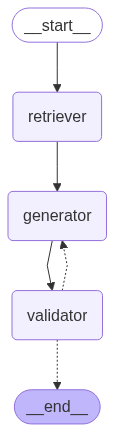

In [458]:
graph = builder.compile()

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))  # Display the graph

We have now created an agent which check two things.
1. Whenever our llm outputs a recipe, the llm in the loop check wether every ingredient is listed in the recipe description
2. A general satisfy the client's question check

In [461]:
initial_state = {
    "input_prompt": "Erzähl mir ein Witz.",
}

result = graph.invoke(initial_state, {"recursion_limit": 10}) # set recursion limit for early stopping of the graph
print(result["answer"].content)


Es tut mir leid, aber in dem gegebenen Kontext befindet sich kein Witz. Ich kann dir aber Rezepte aus dem Kontext geben, wenn du möchtest.


Let us check the feedback that the llm gave.

In [462]:
print(result["validation_feedback"])

Die Antwort ist valide, da sie dem Nutzer mitteilt, dass im gegebenen Kontext kein Witz vorhanden ist, aber Rezepte angeboten werden, falls gewünscht. Es werden keine spezifischen Rezepte genannt, daher ist die Überprüfung der Zutatenlisten nicht erforderlich. Die Frage des Nutzers wurde ausreichend beantwortet, da auf den fehlenden Witz hingewiesen und eine Alternative angeboten wurde. 


As a final last check, we ask our graph what it was actually made for: giving out tasty recipes!

In [466]:
initial_state = {
    "input_prompt": "Gib mir ein Rezept mit Oliven und Tomaten. Am Liebsten etwas auf dem Backofen.",
}

result = graph.invoke(initial_state, {"recursion_limit": 10}) # set recursion limit for early stopping of the graph
print(result["answer"].content)


**Rezeptname**: Tomaten-Quiche

**Zutaten**:
*   Butter für die Form
*   1 Paket frischer Blätterteig (230 g)
*   2 Zweige Thymian
*   2 Knoblauchzehen
*   300 g Gruyère in Scheiben
*   6 Tomaten
*   15 schwarze Oliven mit Stein
*   1 EL Dijon-Senf
*   Pfeffer
*   3 EL Olivenöl

**Zubereitung**:

1.  Den Backofen auf 200 °C Ober- und Unterhitze vorheizen.
2.  Eine Quicheform mit Butter ausstreichen, den Blätterteig ausbreiten, in die Form legen und 15 Minuten in den Kühlschrank stellen.
3.  Den Thymian waschen, trocken schütteln und die Blättchen abzupfen. Den Knoblauch schälen und den Käse in Streifen schneiden.
4.  Die Tomaten waschen und in Scheiben schneiden, den Stielansatz entfernen. Die Oliven vom Stein schneiden und grob hacken.
5.  Den Blätterteig dünn mit Senf bestreichen und den Käse darauf verteilen. Die Tomatenscheiben ringförmig auf den Käse legen und die Oliven darauf verteilen. Mit Thymianblättchen bestreuen und mit Pfeffer würzen.
6.  Olivenöl mit gepresstem Knoblauch 